In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "GPR40"

# Files we are processing
file_path_sdf_active = "./GPR40/docking/GPR40_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./GPR40/docking/GPR40_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./GPR40/strain/GPR40_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./GPR40/strain/GPR40_decoy_docking_lib_sorted.csv"

In [3]:
# Parameters
title_suffix = "ACM3"
file_path_sdf_active = "./ACM3/docking/ACM3_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./ACM3/docking/ACM3_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./ACM3/strain/ACM3_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./ACM3/strain/ACM3_decoy_docking_lib_sorted.csv"


In [4]:
# import matplotx

# plt.style.use(matplotx.styles.tokyo_night["storm"])

In [5]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [6]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [7]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [8]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [9]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])

In [10]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [11]:
# only keep as commented for debug
# pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

# for df in pre_merge:
#     print(df.shape)

In [12]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [13]:
# #only keep as commented for debug
# post_merge = [active_data, decoy_data]

# for df in post_merge:
#     print(df.shape)

In [14]:
all_data = pd.concat([active_data, decoy_data])

#print(all_data.shape)

In [15]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

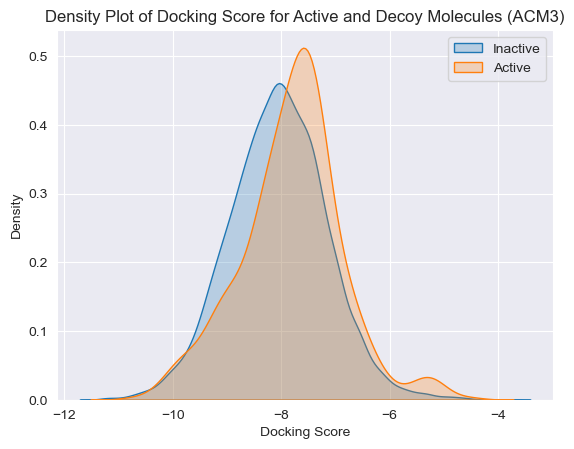

In [16]:
plot_density(all_data, title_suffix)

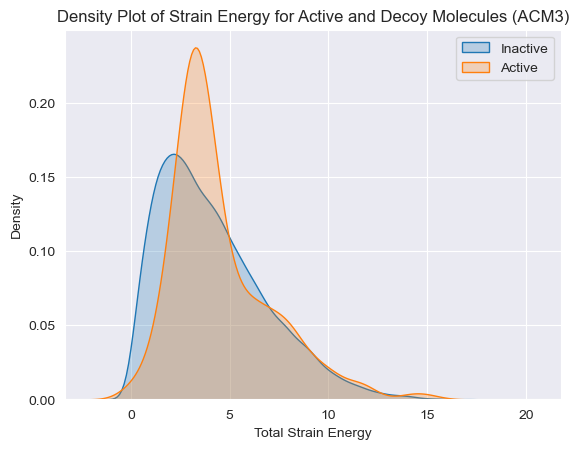

In [17]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Total_E"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()

plot_density_strain(all_data, title_suffix)

In [18]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [19]:
all_data = calculate_enrichment_parameters(all_data)
all_data

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C72663431_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2a2306110>,0,ACM3_chembl19_set_decoy_sc.smi,5403,53161,0,S-OPLS,35.2103,1,C72663431_Isomer2-1,ACM3,5402,2,-11.31780,-0.565891,-1.53606,-2.83248,-11.3178,-3.96545,-0.32,-0,-4.83403,-40.6877,-3.92198,0.424342,0,-67.0644,-44.6097,15.7896,2,136,0,3.018284,2.008044,NaN,1.0,0,462,0.0,0.000066
2,C12663814_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a2306260>,0,ACM3_chembl19_set_decoy_sc.smi,15066,53161,0,S-OPLS,72.2723,1,C12663814_Isomer1-1,ACM3,15064,7,-11.27730,-0.352417,-1.11885,-2.5253,-11.2773,-5.91081,-0.563014,-0,-2.04272,-37.1075,-9.46565,0.514431,0,-79.8163,-46.5731,13.7768,13,133,0,9.058532,6.659158,NaN,0.0,0,462,0.0,0.000131
3,C00978085_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a23061f0>,0,ACM3_chembl19_set_decoy_sc.smi,5428,53161,0,S-OPLS,60.1101,1,C00978085_Isomer1-1,ACM3,5427,2,-11.26810,-0.433389,-1.28391,-2.64628,-11.2681,-4.9889,-0.331042,-0,-3.37657,-34.4345,-7.92652,0.339101,0,-66.1593,-42.361,0.0579167,16,234,0,1.981300,1.424063,inf,1.0,0,462,0.0,0.000197
4,C63479044_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a2306340>,0,ACM3_chembl19_set_decoy_sc.smi,1527,53161,0,S-OPLS,47.7258,1,C63479044_Isomer1-1,ACM3,1526,2,-11.23560,-0.468152,-1.35038,-2.68921,-11.2356,-4.3884,-0.285285,-0,-4.19325,-29.9,-7.99195,0.325081,0,-48.2905,-37.892,11.3321,15,30,0,4.270153,3.009310,NaN,0.0,0,462,0.0,0.000262
5,C75184363_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a23063b0>,0,ACM3_chembl19_set_decoy_sc.smi,14547,53161,0,S-OPLS,23.4476,1,C75184363_Isomer1-1,ACM3,14545,1,-11.22590,-0.623662,-1.63446,-2.88556,-11.2259,-2.82985,-0.191374,-0,-5.70592,-27.1685,-8.27554,0.200998,-0.1,-69.1668,-35.444,0.01963,5,141,0,1.488941,1.155651,2.320687,0.0,0,462,0.0,0.000328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15236,C70051075_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b5be59a0>,0,ACM3_chembl19_set_decoy_sc.smi,2386,53161,0,S-OPLS,16.8192,1,C70051075_Isomer1-1,ACM3,2385,8,-4.17399,-0.298142,-0.718564,-1.147,-4.17399,-3.17506,0,-0,-2.48122,-28.9685,-0.692118,3.03453,0,-36.6543,-29.6606,2.4278,7,208,0,5.894012,5.546278,6.319825,3.0,462,462,1.0,0.999738
15237,C71554630_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b5be5a80>,0,ACM3_chembl19_set_decoy_sc.smi,13684,53161,0,S-OPLS,33.9655,1,C71554630_Isomer1-1,ACM3,13682,4,-4.05914,-0.162366,-0.47476,-0.962138,-4.05914,-2.9906,-0.288501,-0,1.56466,-37.2148,-5.22045,0.316198,-0.0170872,-49.0446,-42.4353,5.89907,14,175,0,6.151030,5.026679,NaN,1.0,462,462,1.0,0.999803
15238,C65493174_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2b5be5af0>,0,ACM3_chembl19_set_decoy_sc.smi,14735,53161,0,S-OPLS,1.35946,1,C65493174_Isomer2-1,ACM3,14733,6,-3.91050,-0.23003,-0.591471,-1.02016,-3.9105,-3.25671,0,-0,-2.52863,-30.3886,-2.02209,3.69758,0,-36.8074,-32.4107,7.88571,129,47,0,6.544900,4.966269,NaN,5.0,462,462,1.0,0.999869
15239,C70051075_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2b5be5b60>,0,ACM3_chembl19_set_decoy_sc.smi,2387,53161,0,S-OPLS,17.4505,1,C70051075_Isomer2-1,ACM3,2386,8,-3.90348,-0.27882,-0.671997,-1.07266,-3.90348,-2.77069,0,-0,-2.46433,-29.7678,-1.43069,3.03453,0,-38.1599,-31.1985,1.69963,43,118,0,5.324964,5.117135

In [20]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [21]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [22]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

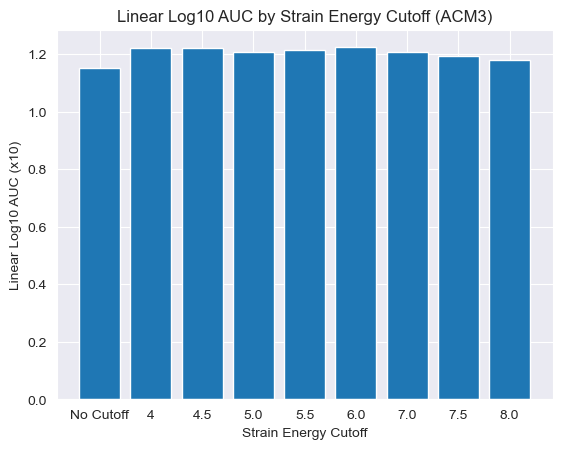

In [23]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

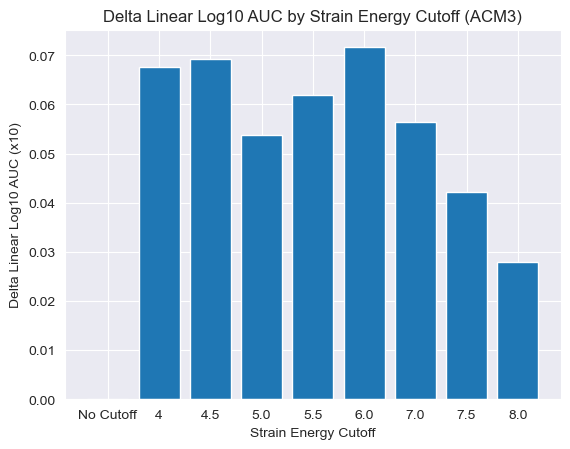

In [24]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [25]:
def write_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    # print(f"Delta LogAUCs for {title_suffix}: {delta_log_aucs}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "Linear Log10 AUC (x10)": log_aucs,
        "Delta Linear Log10 AUC (x10)": delta_log_aucs
    })

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_log_aucs_{title_suffix}.csv", index=False)

write_log_aucs(all_data, total_e_thresholds, title_suffix)

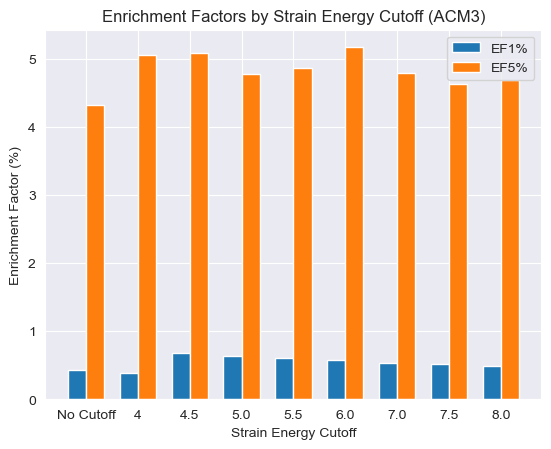

In [26]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]) * 100

    # print(df.shape)

    # print(
    #     f"1% Closest Cumulative_Actives: {closest_to_one_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"1% Closest Total_Actives: {closest_to_one_percent['Total_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Cumulative_Actives: {closest_to_five_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Total_Actives: {closest_to_five_percent['Total_Actives'].values[0]}"
    # )

    return ef1, ef5


def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # print(f"EF1% for {title_suffix}: {ef1s}")
    # print(f"EF5% for {title_suffix}: {ef5s}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width/2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width/2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()

bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_48387/2506411786.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


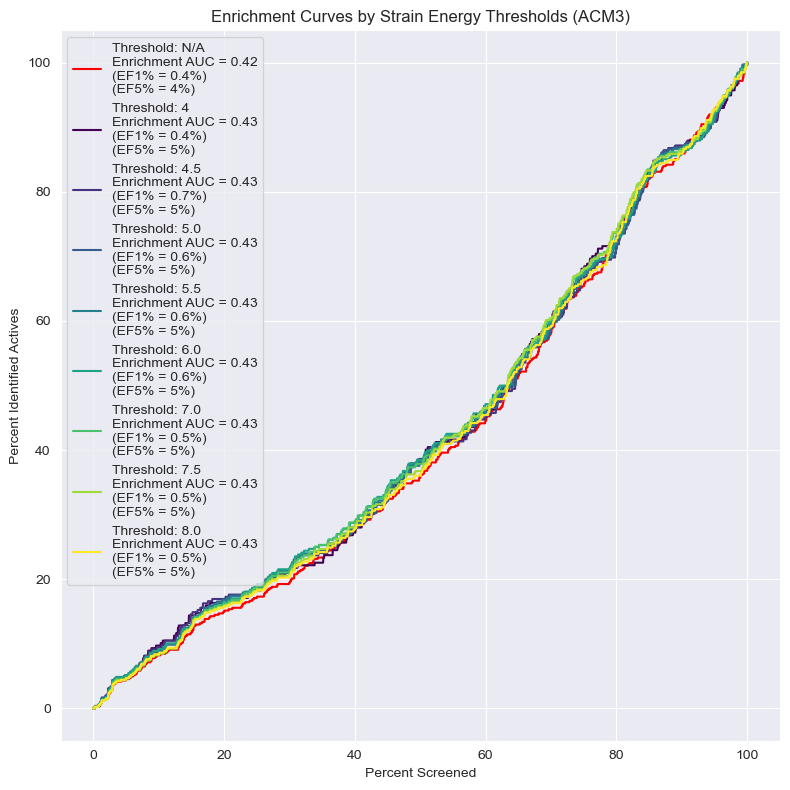

In [27]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color='blue'):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else 'N/A',
            enrichment_auc, ef1, ef5
            ),
        color=color
        )

    # # Add axis labels and title
    # plt.xlabel("Compounds Screened (%)")
    # plt.ylabel("Percent of Identified Actives (%)")
    # plt.title(f"Enrichment Curve ({title_suffix})")

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(
        figsize=(8, 8)
        )

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Enrichment Curves by Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()

plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [28]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "EF1%": ef1s,
        "EF5%": ef5s
    })

    print(f"Writing CSV to strain_enrichment_metrics_{title_suffix}.csv")
    df.to_csv(f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False)
    print("CSV writing complete.")

    try:
        df.to_csv(
            f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False
        )
        print("CSV writing complete.")
    except Exception as e:
        print(f"Failed to write CSV: {e}")

write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)

Writing CSV to strain_enrichment_metrics_ACM3.csv
CSV writing complete.
CSV writing complete.


In [29]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [30]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_48387/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


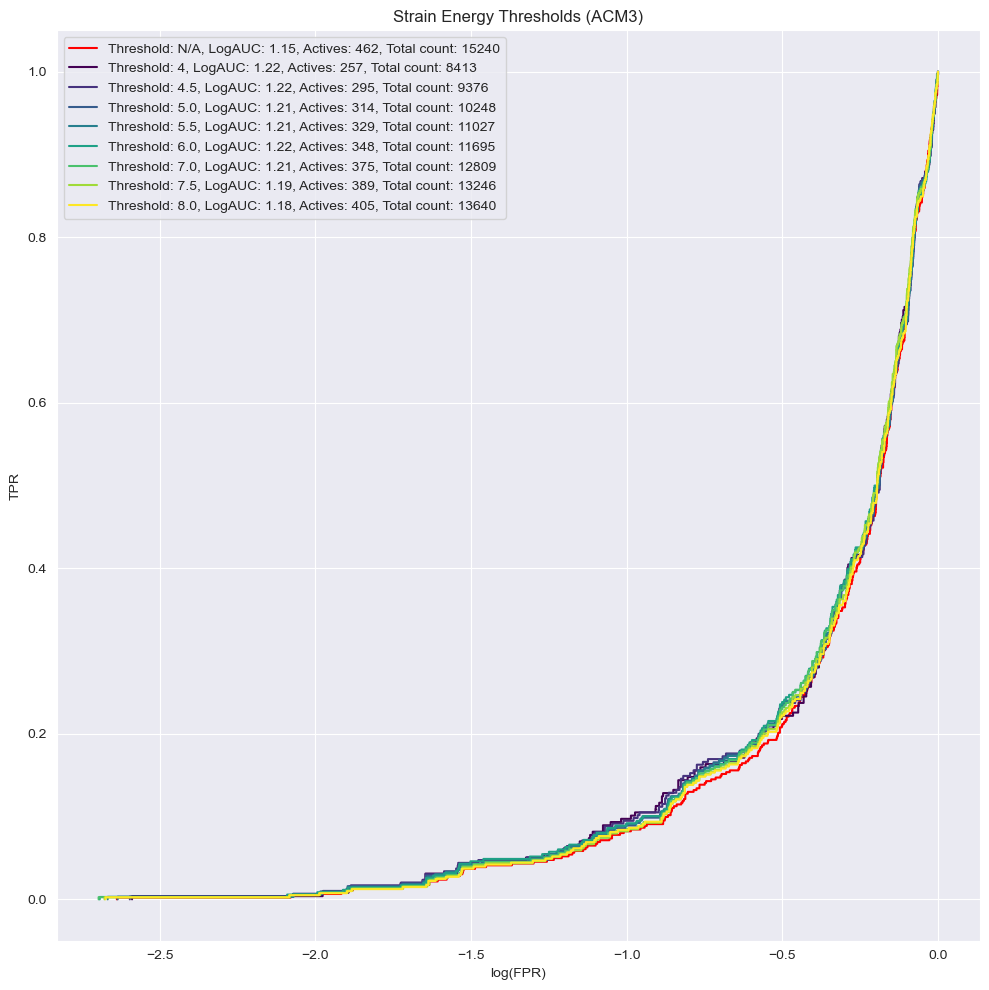

In [31]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_48387/2191446731.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


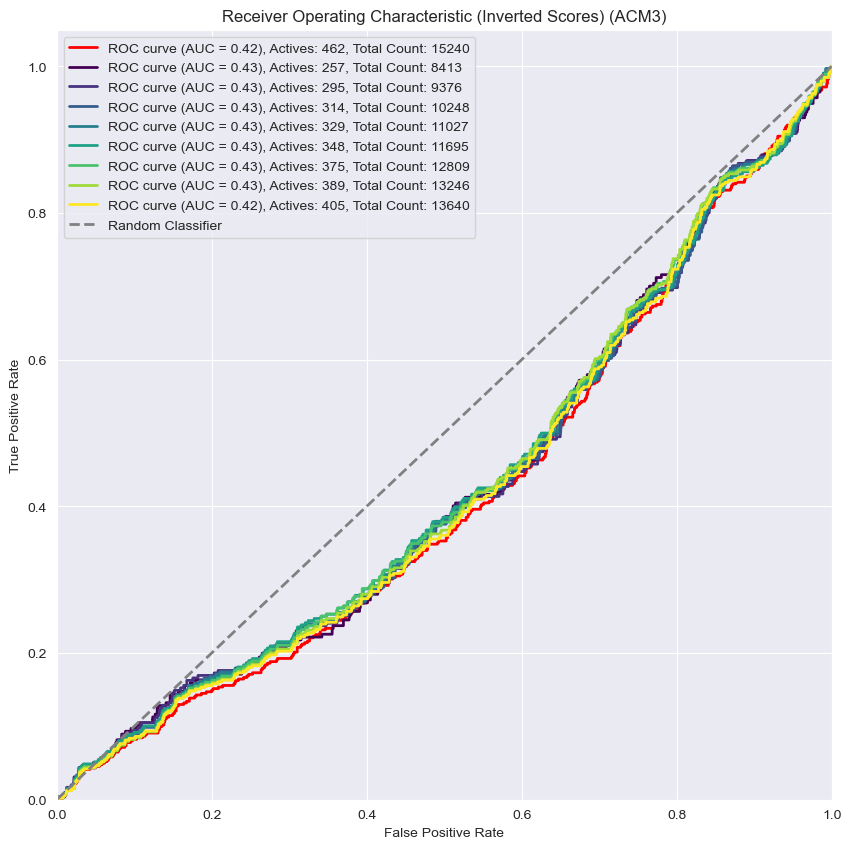

In [32]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color='blue'):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Total_E' column. If this is not None, the data is filtered to only include rows where 'Total_E' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Total_E' threshold
    df = data if total_e_threshold is None else data[data["Total_E"] <= total_e_threshold]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")

def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data,
            total_e_threshold=t,
            ax=ax,
            title_suffix=title_suffix,
            color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey")

    ax.legend()

    plt.show()

plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [33]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Total_E' threshold
        df = data if t is None else data[data["Total_E"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append({
            "Protein": title_suffix,
            "Strain Energy Cutoff": t if t is not None else 'No Cutoff',
            "ROC_AUC": roc_auc,
            "Actives": activity_1_count,
            "Total Count": total_count
        })

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_roc_metrics_{title_suffix}.csv", index=False)

write_roc_metrics(all_data, total_e_thresholds, title_suffix)

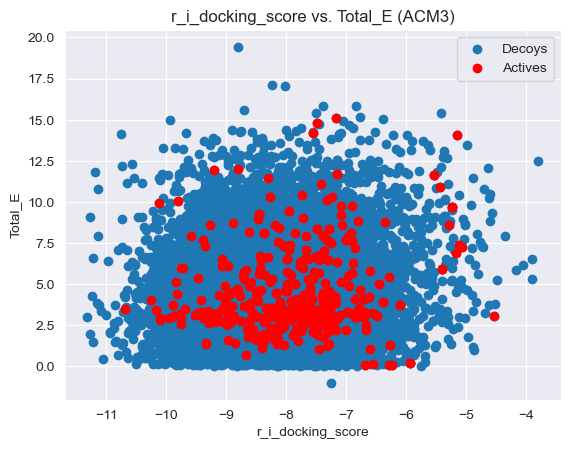

In [34]:
plt.scatter(all_data["r_i_docking_score"], all_data["Total_E"])
actives_all_data = all_data[all_data["Activity"] == 1]
plt.scatter(actives_all_data["r_i_docking_score"], actives_all_data["Total_E"], c="red")
plt.title(f"r_i_docking_score vs. Total_E ({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")
plt.legend(["Decoys", "Actives"])
plt.show()

In [35]:
all_data_NegativeStrain=all_data[all_data["Total_E"] <= 0]
all_data_NegativeStrain

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
12612,C38621353_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b2c57f40>,0,ACM3_chembl19_set_decoy_sc.smi,9047,53161,0,S-OPLS,35.3498,1,C38621353_Isomer1-1,ACM3,9045,7,-7.24752,-0.278751,-0.825798,-1.70206,-7.24752,-3.54548,0,-0,-2.03586,-38.8872,-1.91148,0.564902,0,-44.4914,-40.7987,14.3009,9,365,0,-1.0,0.0,0.0,1.0,364,462,0.787879,0.827559


In [36]:
# print Molecule_Name for all rows with Total_E <= 0
for index, row in all_data_NegativeStrain.iterrows():
    print(row['Molecule_Name'])

C38621353_Isomer1


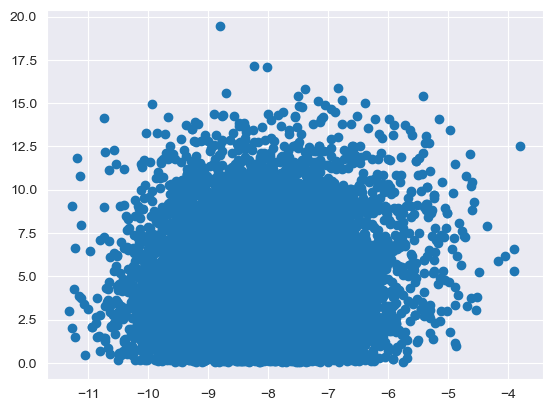

In [37]:
all_data_positive = all_data[all_data["Total_E"] >= 0]
plt.scatter(all_data_positive["r_i_docking_score"], all_data_positive["Total_E"])

In [38]:
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

In [39]:
def identify_pareto(scores):
    population_size = scores.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                pareto_front[i] = 0
                break
    return np.where(pareto_front == 1)[0]


def find_pareto_ranks(scores, max_ranks=100):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    for _ in range(max_ranks):
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
        if remaining_scores.shape[0] == 0:
            break
    return ranks



In [40]:
data = all_data_positive

In [41]:
# Extract the scores for the entire dataset
scores = data[["r_i_docking_score", "Total_E"]].values

# Find the ranks of Pareto fronts until all points are classified or a max limit is reached
pareto_ranks_indices = find_pareto_ranks(
    scores, max_ranks=20
)  # Adjust max_ranks as needed

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_48387/1624393553.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))


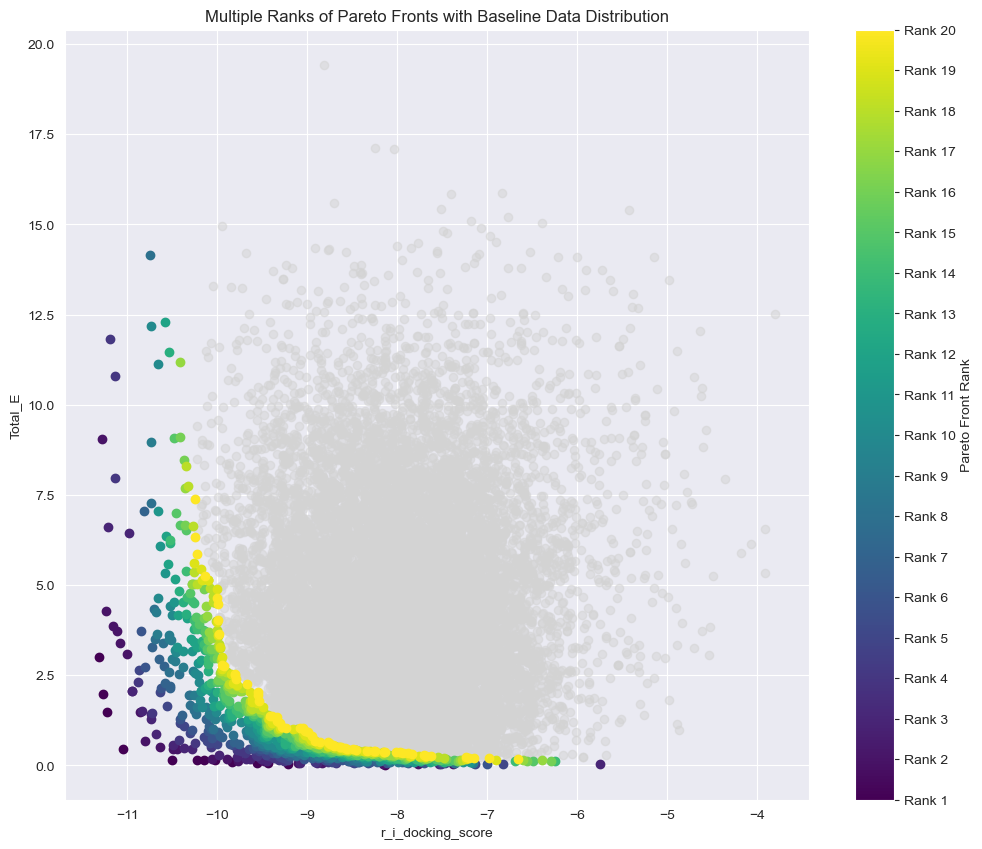

In [42]:
# Determine the actual number of ranks found
num_ranks = len(pareto_ranks_indices)

# Plot the baseline data distribution
plt.figure(figsize=(12, 10))
plt.scatter(
    data["r_i_docking_score"],
    data["Total_E"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

# Generate colors for each rank dynamically using a colormap
colormap = viridis
norm = Normalize(vmin=0, vmax=num_ranks - 1)

for i, indices in enumerate(pareto_ranks_indices):
    rank_data = data.iloc[indices]
    plt.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Total_E"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

plt.title("Multiple Ranks of Pareto Fronts with Baseline Data Distribution")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")

# Create a custom legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))
cbar.ax.set_yticklabels([f"Rank {i+1}" for i in range(num_ranks)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()

In [43]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")

Number of Pareto points per rank:
Rank 1: 13 points
Rank 2: 21 points
Rank 3: 20 points
Rank 4: 22 points
Rank 5: 28 points
Rank 6: 26 points
Rank 7: 36 points
Rank 8: 36 points
Rank 9: 40 points
Rank 10: 42 points
Rank 11: 41 points
Rank 12: 50 points
Rank 13: 45 points
Rank 14: 58 points
Rank 15: 52 points
Rank 16: 56 points
Rank 17: 54 points
Rank 18: 61 points
Rank 19: 52 points
Rank 20: 60 points

Total Pareto points across all ranks: 813


In [44]:
all_pareto_ranks_indices = np.concatenate(pareto_ranks_indices)
display(data.iloc[all_pareto_ranks_indices])

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C72663431_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2a2306110>,0,ACM3_chembl19_set_decoy_sc.smi,5403,53161,0,S-OPLS,35.2103,1,C72663431_Isomer2-1,ACM3,5402,2,-11.31780,-0.565891,-1.53606,-2.83248,-11.3178,-3.96545,-0.32,-0,-4.83403,-40.6877,-3.92198,0.424342,0,-67.0644,-44.6097,15.7896,2,136,0,3.018284,2.008044,NaN,1.0,0,462,0.000000,0.000066
3,C00978085_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a23061f0>,0,ACM3_chembl19_set_decoy_sc.smi,5428,53161,0,S-OPLS,60.1101,1,C00978085_Isomer1-1,ACM3,5427,2,-11.26810,-0.433389,-1.28391,-2.64628,-11.2681,-4.9889,-0.331042,-0,-3.37657,-34.4345,-7.92652,0.339101,0,-66.1593,-42.361,0.0579167,16,234,0,1.981300,1.424063,inf,1.0,0,462,0.000000,0.000197
5,C75184363_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a23063b0>,0,ACM3_chembl19_set_decoy_sc.smi,14547,53161,0,S-OPLS,23.4476,1,C75184363_Isomer1-1,ACM3,14545,1,-11.22590,-0.623662,-1.63446,-2.88556,-11.2259,-2.82985,-0.191374,-0,-5.70592,-27.1685,-8.27554,0.200998,-0.1,-69.1668,-35.444,0.01963,5,141,0,1.488941,1.155651,2.320687,0.0,0,462,0.000000,0.000328
13,C18152200_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a2306500>,0,ACM3_chembl19_set_decoy_sc.smi,2732,53161,0,S-OPLS,16.6409,1,C18152200_Isomer1-1,ACM3,2731,2,-11.05180,-0.442071,-1.29262,-2.6196,-11.0518,-3.47658,-0.566182,-0,-4.28616,-36.9098,-7.3909,0.231285,0,-59.678,-44.3007,3.19006,7,39,0,0.452473,0.345213,0.568983,0.0,0,462,0.000000,0.000853
65,C63351124_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a2307d80>,0,ACM3_chembl19_set_decoy_sc.smi,1194,53161,0,S-OPLS,31.5033,1,C63351124_Isomer1-1,ACM3,1193,1,-10.50270,-0.500126,-1.37981,-2.59676,-10.5027,-2.79483,0,-0,-5.51113,-38.8712,-1.68754,0,0,-63.8915,-40.5588,1.474,1,252,0,0.162178,0.093702,0.239290,0.0,1,462,0.002165,0.004265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12719,C74937771_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b2c96ab0>,0,ACM3_chembl19_set_decoy_sc.smi,11236,53161,0,S-OPLS,11.6814,1,C74937771_Isomer1-1,ACM3,11234,1,-7.22781,-0.516272,-1.24429,-1.98618,-7.22781,-2.31855,0,-0,-3.19745,-29.0983,-1.47264,0,-0.0359947,-43.6786,-30.571,0.295744,1,258,0,0.223631,0.170493,0.281136,0.0,371,462,0.803030,0.834580
12811,C35324725_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b2cd5310>,0,ACM3_chembl19_set_decoy_sc.smi,6353,53161,0,S-OPLS,33.0618,1,C35324725_Isomer1-1,ACM3,6351,1,-7.20176,-0.45011,-1.13421,-1.90897,-7.20176,-2.09171,-0.32,-0,-3.22163,-31.0245,-1.6874,0.235919,0,-49.9848,-32.7119,0.311568,1,27,0,0.203570,0.114268,0.307308,0.0,373,462,0.807359,0.840617
13049,C04237830_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b3f176f0>,0,ACM3_chembl19_set_decoy_sc.smi,5477,53161,0,S-OPLS,19.915,1,C04237830_Isomer1-1,ACM3,5476,1,-7.14485,-0.420285,-1.08067,-1.86393,-7.14485,-2.98773,0,-0,-2.55027,-34.4302,-0.248984,0.152004,0,-48.0564,-34.6792,0.229654,1,324,0,0.198670,0.114787,0.294800,0.0,383,462,0.829004,0.856234
13606,C22156183_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b4916810>,0,ACM3_chembl19_set_decoy_sc.smi,1135,53161,0,S-OPLS,48.4803,1,C22156183_Isomer1-1,ACM3,1134,1,-6.97854,-0.436159,-1.09905,-1.8498,-6.97854,-2.32538,0,-0,-3.04041,-34.7248,-0.735972,0.233885,0,-50.2291,-35.4607,

In [45]:
pareto_front_df = data.iloc[all_pareto_ranks_indices]

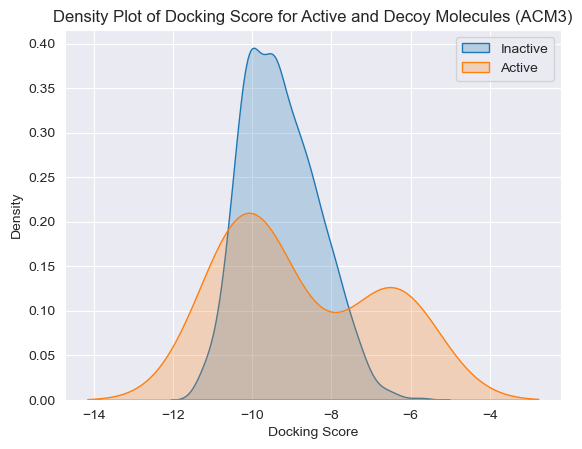

In [46]:
plot_density(pareto_front_df, title_suffix)

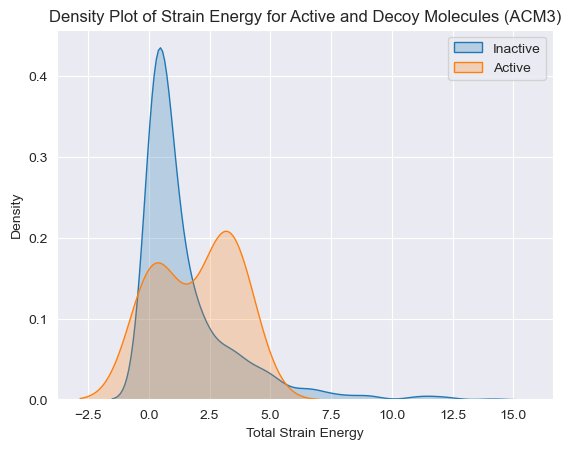

In [47]:
plot_density_strain(pareto_front_df, title_suffix)

In [48]:
pareto_front_df = calculate_enrichment_parameters(pareto_front_df)

In [49]:
def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Calculate the enrichment at the closest value to 1%
    # Subtract 0.01 (1%) from the 'Percentage_Screened' column and find the absolute value
    # (df['Percentage_Screened'] - 0.01).abs()
    # Sort the resulting series and take the first index (smallest difference)
    # (df['Percentage_Screened'] - 0.01).abs().argsort()[:1]
    # Use the index to get the row from the dataframe
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    )

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_five_percent = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    )

    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            enrichment_auc,
            enrichment_at_one_percent * 100,
            enrichment_at_five_percent * 100,
        ),
    )

    #   # Plot the enrichment at 1%
    #   plt.scatter(
    #   1,
    #   enrichment_at_one_percent * 100,
    #   s=0,
    #   color='black',
    #   label="Enrichment (%) at 1% = {:.2f}".format(enrichment_at_one_percent*100),
    # )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Percent of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()


In [50]:
threshold4 = all_data[all_data["Total_E"] <= 4]
threshold4 = calculate_enrichment_parameters(threshold4)

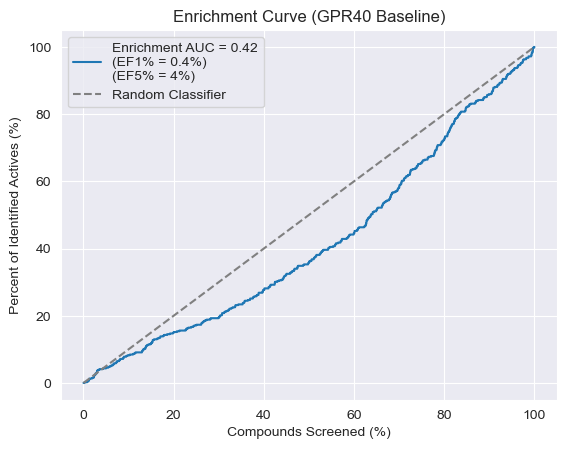

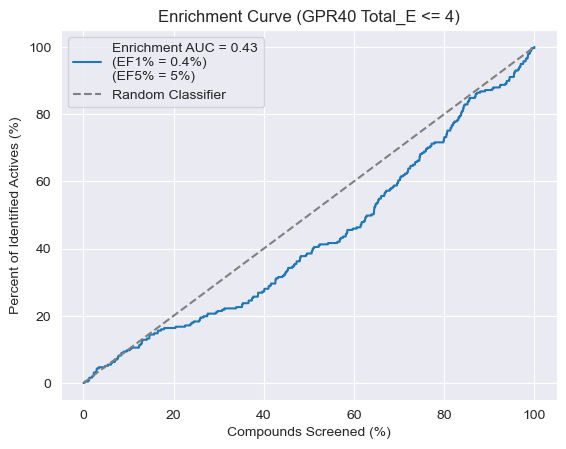

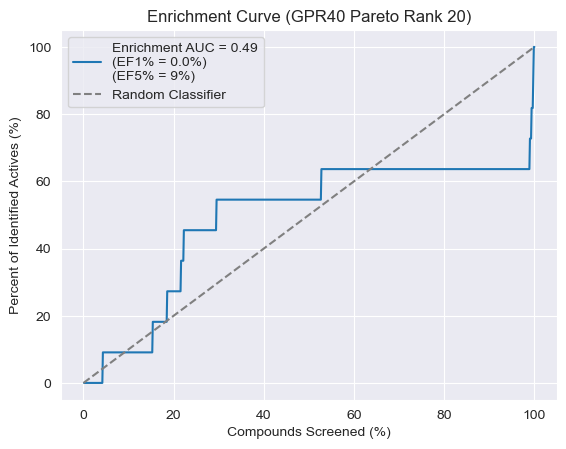

In [51]:
plot_enrichment_curve_classifier(all_data, "GPR40 Baseline")
plot_enrichment_curve_classifier(threshold4, "GPR40 Total_E <= 4")
plot_enrichment_curve_classifier(pareto_front_df, "GPR40 Pareto Rank 20")